In [5]:
%cd '/home/naodell/work/CMS/amumu'
%matplotlib notebook

import sys                       
                                 
import numpy as np               
import pandas as pd              
import matplotlib.pyplot as plt  
import seaborn as sns
from tqdm import tqdm            
import nllfitter.plot_tools as pt


/home/naodell/work/CMS/amumu


# Met (kluge) corrections
The bacon production 12 had a bug in the MET corrections.  This was addressed for data, but not for MC.  To account for this, I will compare events that overlap between the old and new data ntuples and correct the MC samples accordingly.

In [6]:

datasets    = [                                                      
               'muon_2016B', 'muon_2016C', 'muon_2016D',            
               'muon_2016E', 'muon_2016F', 'muon_2016G', 'muon_2016H'
              ]        

dm = pt.DataManager(input_dir     = 'data/flatuples/mumu_2016',   
                    dataset_names = datasets,
                    period        = 2016,  
                    selection     = 'mumu'   
                   )       
df1 = dm.get_dataframe('data')
dm = pt.DataManager(input_dir     = 'data/flatuples/mumu_rereco_2016',   
                    dataset_names = datasets,
                    period        = 2016,  
                    selection     = 'mumu'   
                   )                         
df2 = dm.get_dataframe('data')

Loading dataframes: 100%|███████████████| 7.00/7.00 [00:01<00:00, 3.89it/s]
Loading dataframes: 100%|███████████████| 7.00/7.00 [00:01<00:00, 3.83it/s]


Now let's prepare the overlap.

In [7]:
df1 = df1.set_index(['run_number', 'event_number'])
df2 = df2.set_index(['run_number', 'event_number'])

mask = df1.index.intersection(df2.index)
df1 = df1.loc[mask]
df2 = df2.loc[mask]

The correction factor will be:

$$
k = \frac{MET_{data,new}}{MET_{data,old}}MET_{MC}
$$

In [11]:
h, bins, _ = plt.hist([df2.met_mag, df1.met_mag], bins='fd', range=(0., 200.), histtype='step')
plt.yscale('log')
plt.show()

<IPython.core.display.Javascript object>


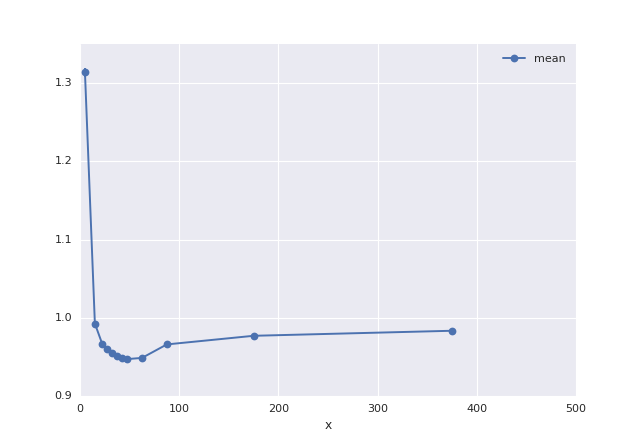

In [49]:
met_ratio = df1.met_mag.values/df2.met_mag.values
df_corr = pd.DataFrame({'k':met_ratio, 'met':df2.met_mag.values})
df_corr = df_corr[df_corr.met < 500]

bins = np.array([0., 10., 20., 25., 30., 35., 40., 45., 50., 75., 100., 250., 500.])
df_corr['bins'] = np.digitize(df_corr.met, bins=bins)
g_corr = df_corr.groupby('bins')
res_corr = g_corr['k'].agg(['mean', 'sem'])
res_corr['x'] = (bins[:-1] + bins[1:])/2.
res_corr['xlow'] = bins[:-1]
res_corr['xhigh'] = bins[1:]
res_corr.to_csv('data/met_kluge.')
res_corr.plot('x', 'mean', yerr='sem', marker='o')
plt.xlim(0, 500)
plt.show()